The purpose of this notebook is to explore plotting drifters in each region, colour by drifter type.

In [1]:
import os
import datetime
import json
import glob
import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Point, Polygon
import xarray as xr


from driftutils import utils
from driftutils.assemble_drifter_metadata import assemble_drifter_metadata
from plotutils import plotting_utils as putils

%matplotlib inline

In [2]:
data_dir = '/home/jmm000/work/Drifters/output/TechReport2023/netcdf/'

In [3]:
assemble_drifter_metadata(data_dir, 'all_drifters.json')

In [4]:
with open('all_drifters.json', 'r') as f:
    metadata = json.load(f)

## Now explore plotting the regions

In [5]:
def load_polygon_coordinates(filename):
    '''Load the poylgon coordinate file and return a dictionary 
    with the shaplel Polygon for each region defined in the 
    coordinate file'''

    with open(filename, 'r') as f:
        poly_coords = yaml.safe_load(f)
    regions = {}
    for region in poly_coords['polygon_coords']:
        coords = poly_coords['polygon_coords'][region]
        new_coords = [(lon, lat) for lat, lon in coords ]
        regions[region] = Polygon(new_coords)
    return regions

In [6]:
def identify_drifters_region(region, metadata):
    drifters  = []
    for d in metadata['drifters']:
        launch_lat = float(d['first_latitude_observation'])
        launch_lon = float(d['first_longitude_observation'])
        launch_coord = Point((launch_lon, launch_lat))
        if launch_coord.within(region):
            drifters.append(d['filename'])
    return drifters

In [7]:
def plot_drifters(drifter_files, ax, lw=0.5, begin_kwargs={}, end_kwargs={}):
    types = []
    for drifter_file in drifter_files:
        d = xr.open_dataset(drifter_file)
        drifter_type = d.type
        if drifter_type not in types:
            types.append(drifter_type)
        ax.plot(d.LONGITUDE, d.LATITUDE, color=colors[drifter_type], 
                transform=ccrs.PlateCarree(),linewidth=lw)
        # plotstart and end points
        ax.plot(d.LONGITUDE[0], d.LATITUDE[0], 
                transform=ccrs.PlateCarree(), zorder=10, **begin_kwargs)
        ax.plot(d.LONGITUDE[-1], d.LATITUDE[-1],
                transform=ccrs.PlateCarree(), zorder=10, **end_kwargs)
    return types

In [8]:
colors = {'CODE/Davis': 'C0', 
          'iSVP': 'C1', 
          'Stokes': 'C2', 
          'Spotter': 'C3', 
          'OSKER': 'C4', 
          'iSphere': 'C5'}

In [9]:
def add_inset(ax, drifters, width, height, lon_min, lon_max, lat_min, lat_max, anchor):
    """add an inset with a zoom specificied by lon/lat coordinates"""
    axins = inset_axes(ax, width=width, height=height,
                       bbox_to_anchor=anchor, bbox_transform=ax.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes,
                       axes_kwargs={'map_projection': ccrs.PlateCarree()})
    plot_drifters(drifters, axins, begin_kwargs=begin_dot_kwargs, end_kwargs=end_dot_kwargs)
    axins.set_extent([lon_min, lon_max, lat_min, lat_max])
    axins.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5)
    ax.plot([lon_min, lon_min, lon_max, lon_max,lon_min,], [lat_min, lat_max, lat_max, lat_min, lat_min],
            'red', transform=ccrs.PlateCarree())

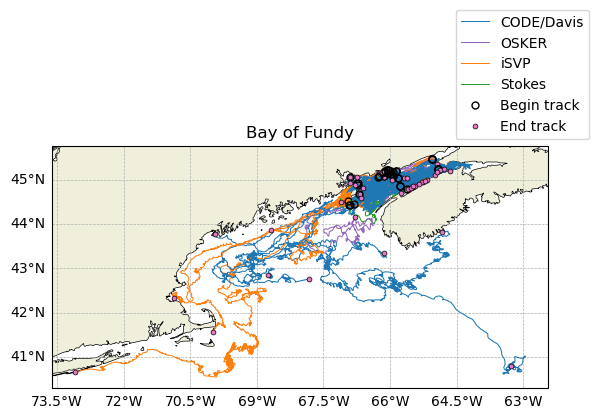

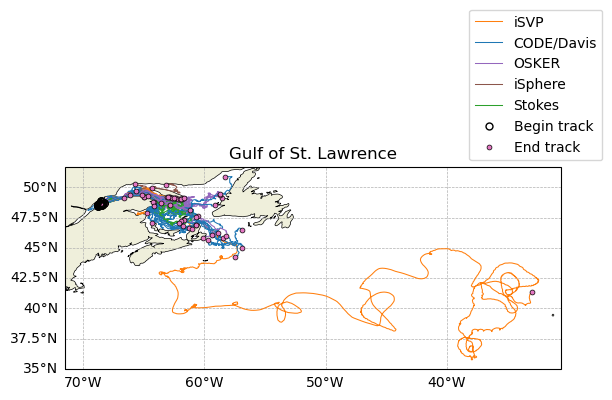

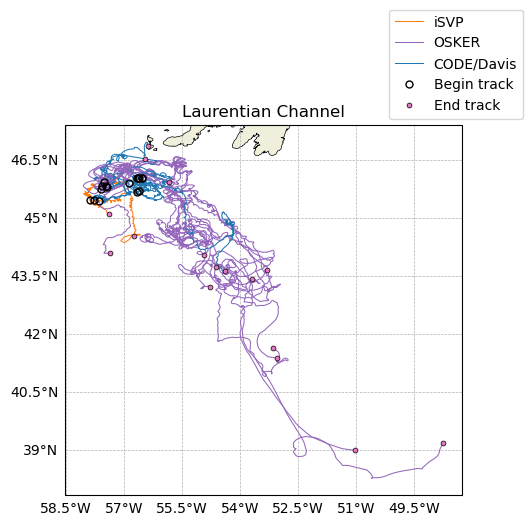

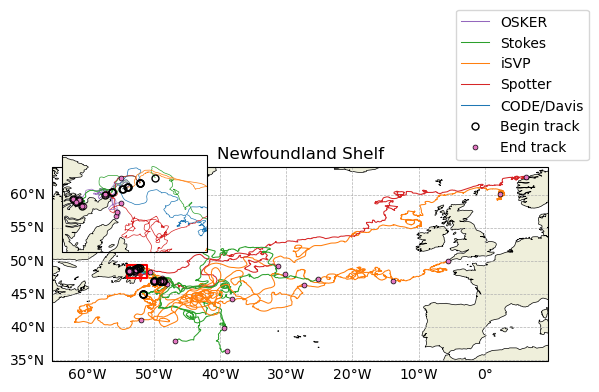

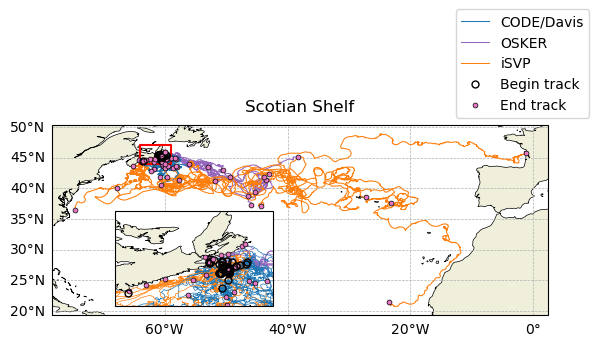

In [10]:
linewidth=0.75
regions = load_polygon_coordinates('drifter-regions.yaml')
begin_dot_kwargs = {'color': 'k', 
                    'marker': 'o',
                    'linewidth': 0, 
                    'markerfacecolor': "None", 
                    'markersize': 5,}
end_dot_kwargs = {'color': 'C6', 
                 'marker': '.',
                 'linewidth': 0, 
                 'markersize': 7,
                 'markeredgecolor':'k',
                 'markeredgewidth': 0.5}

for region in regions:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, )
    poly = regions[region]
    drifters = identify_drifters_region(poly, metadata)
    types = plot_drifters(drifters, ax, lw=linewidth, 
                          begin_kwargs=begin_dot_kwargs,
                          end_kwargs=end_dot_kwargs)
    handles = [Line2D([0], [0], label=drifter_type, color=colors[drifter_type], linewidth=linewidth)
               for drifter_type in types]
    handles.append(Line2D([0], [0], label='Begin track', **begin_dot_kwargs))
    handles.append(Line2D([0], [0], label='End track', **end_dot_kwargs))
    ax.set_title(region)
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5)
    ax.gridlines(draw_labels=["bottom", "left"],zorder=0,linewidth=0.5, linestyle='--')
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.8, 1))
    
    if region == 'Newfoundland Shelf':
        add_inset(ax, drifters, "100%", "50%", -54, -51, 47.5, 49.5, (-.32,.1, 1, 1) )
        
    elif region == "Scotian Shelf":
        add_inset(ax, drifters, "100%", "50%", -64, -59, 44, 47, (-.2,-.415, 1, 1) )